# Boston housing values  

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

# Load original Boston housing dataset

In [3]:
boston = pd.read_csv("Boston.csv")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,538.0,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,469.0,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,469.0,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,458.0,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,458.0,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**Data description**  
CRIM:     per capita crime rate by town  
ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.  
INDUS:    proportion of non-retail business acres per town  
CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)  
NOX:      nitric oxides concentration (parts per 10 million)  
RM:       average number of rooms per dwelling  
AGE:      proportion of owner-occupied units built prior to 1940  
DIS:      weighted distances to five Boston employment centres  
RAD:      index of accessibility to radial highways  
TAX:      full-value property-tax rate per $\$10,000$  
PTRATIO:  pupil-teacher ratio by town  
BLACK:    $1000(Bk - 0.63)^2$ where $Bk$ is the proportion of blacks by town  
LSTAT:    \% lower status of the population  
MEDV:     Median value of owner-occupied homes in $1000's  

In [4]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,4.673727,11.363636,11.136779,0.069170,465.069952,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,25.223207,23.322453,6.860353,0.253994,222.311286,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.400000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,429.000000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,504.000000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.689388,12.500000,18.100000,0.000000,605.000000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,537.000000,100.000000,27.740000,1.000000,871.000000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


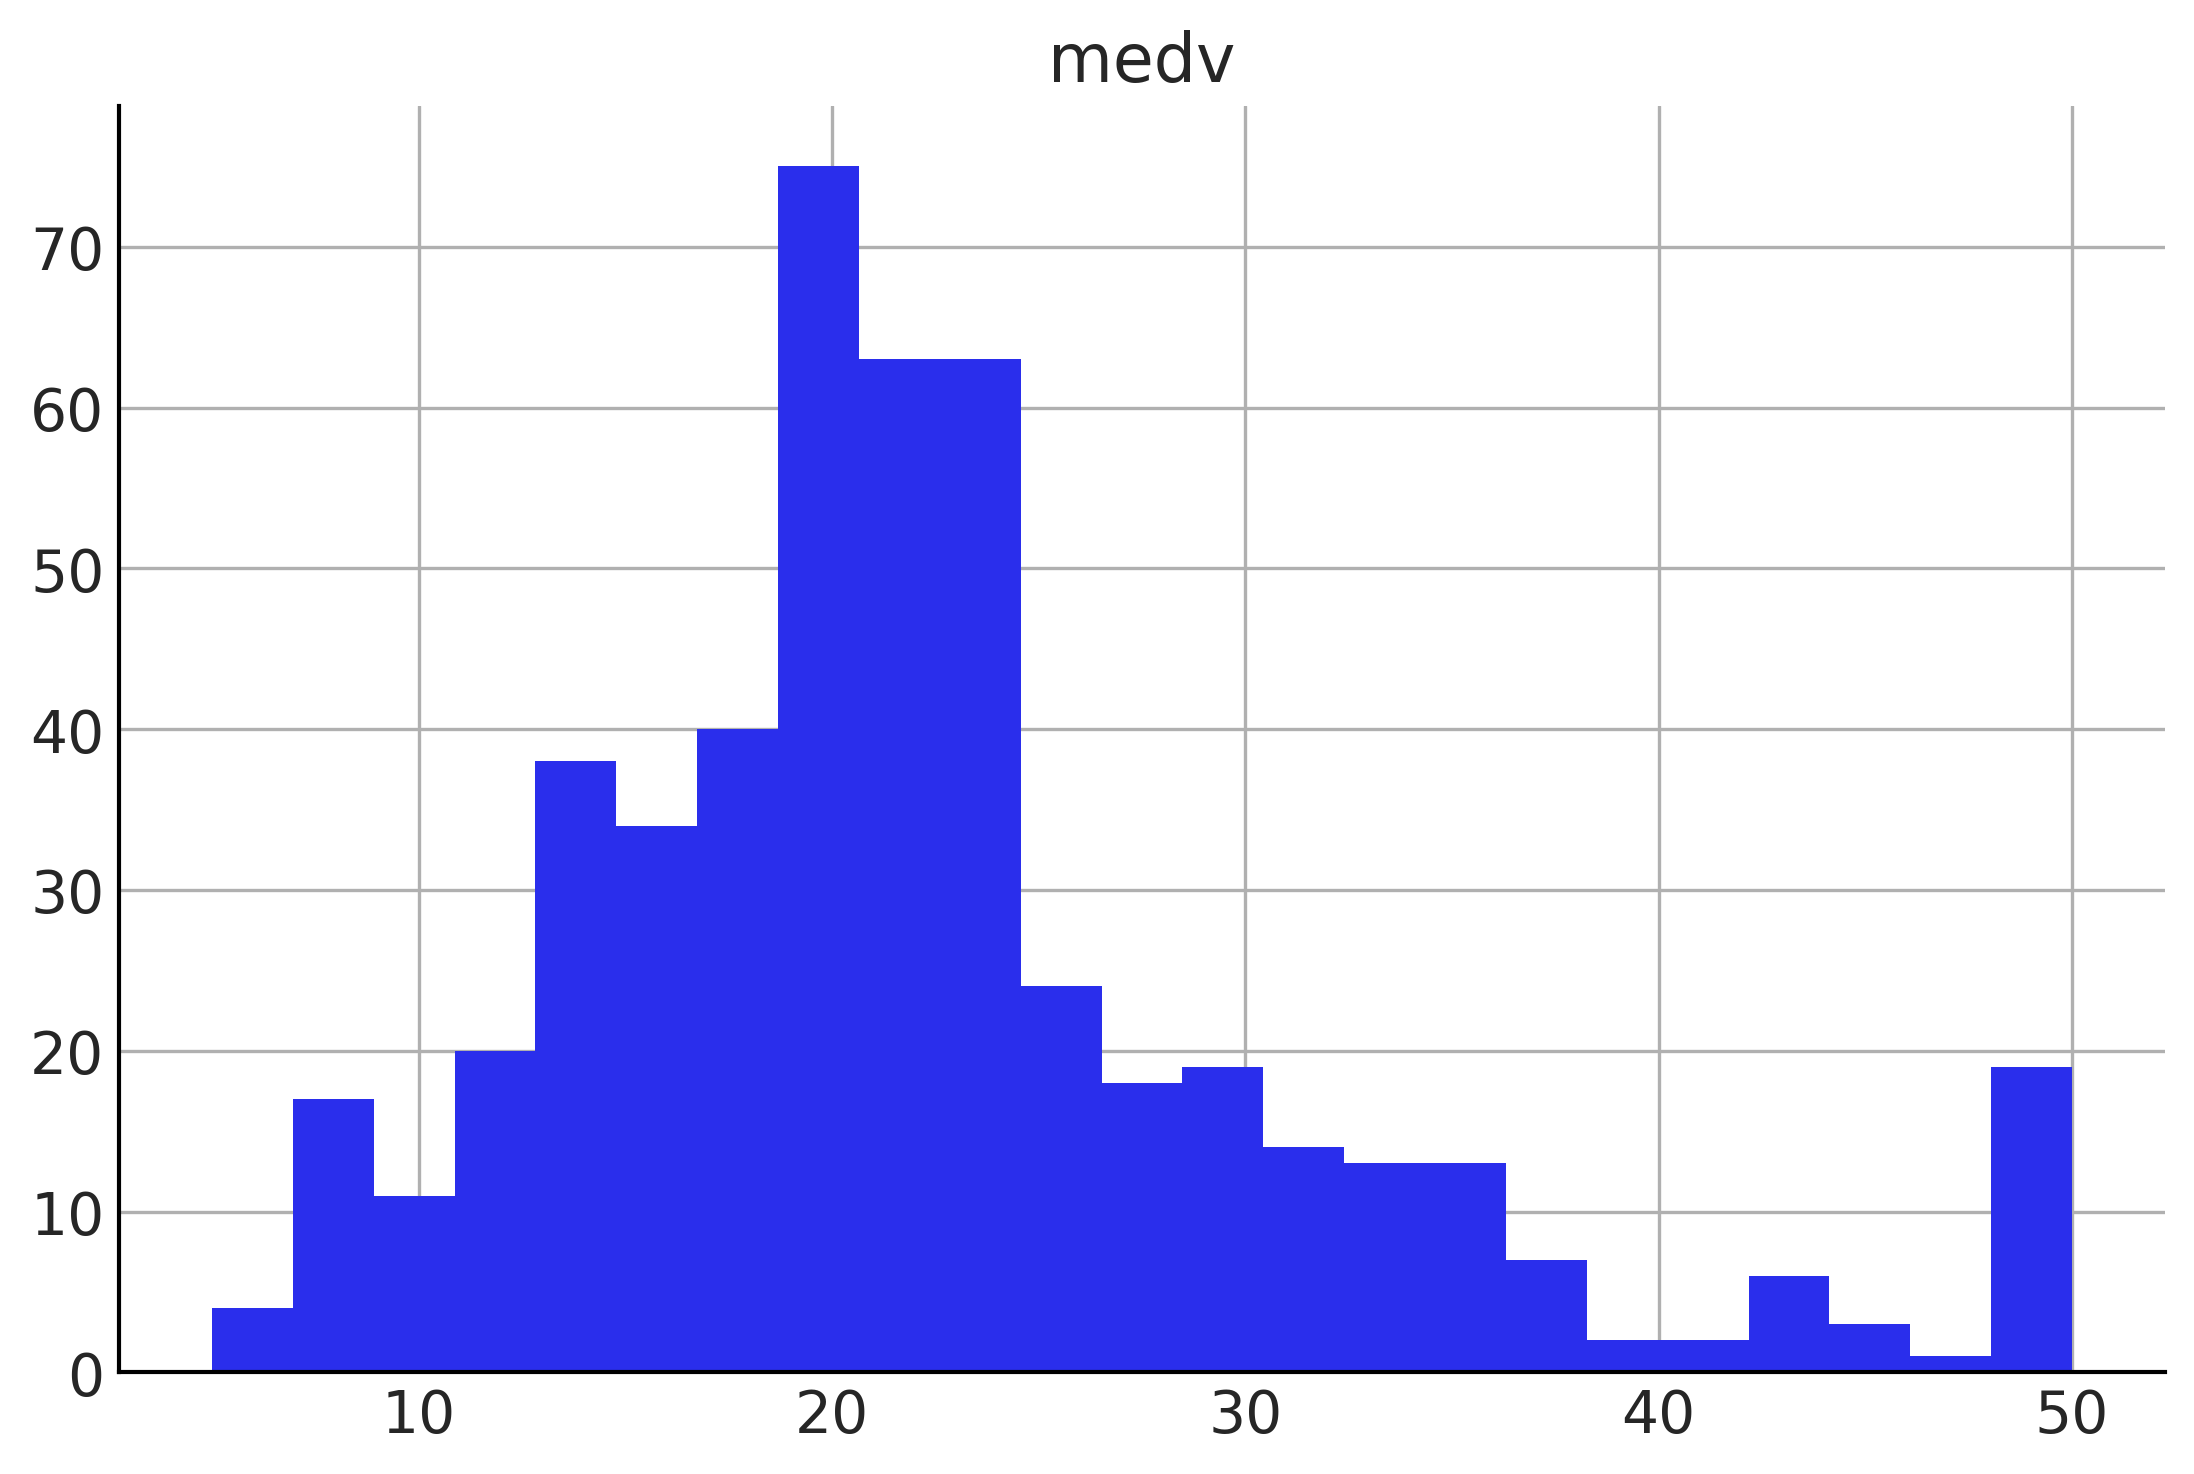

In [5]:
# Histogram for medv values
boston.hist(column="medv", bins="auto");

## With Gamma distribution  
### Using the two most important variables  

In [6]:
X1 = boston[["rm", "lstat"]]
Y = boston["medv"]

In [7]:
X1.head()

,rm,lstat
0,6.575,4.98
1,6.421,9.14
2,7.185,4.03
3,6.998,2.94
4,7.147,5.33


In [8]:
with pm.Model() as model:
    α = pm.HalfNormal("α", 20)
    μ_ = pmb.BART("μ_", X1, np.log(Y), m=200)
    μ = pm.Deterministic("μ", np.exp(μ_))
    sigma = (μ**2 / α) ** 0.5
    y = pm.Gamma("y", mu=μ, sigma=sigma, observed=Y)
    idata = pm.sample(
        chains=4, random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 285 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


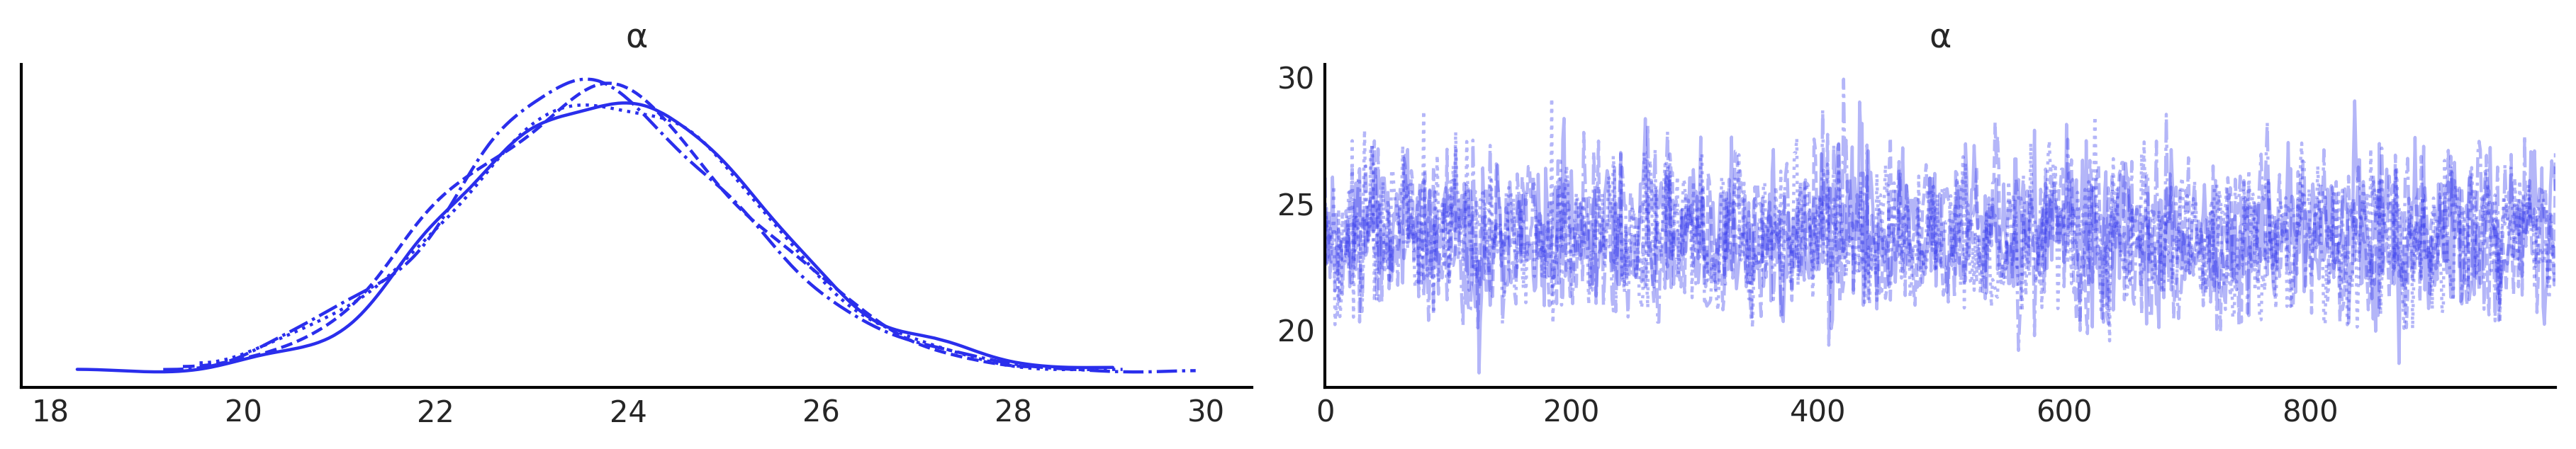

In [9]:
az.plot_trace(idata, var_names=["α"]);

In [10]:
az.loo(idata)

Computed from 4000 posterior samples and 506 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1467.72    24.42
p_loo       23.51        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      506  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
idata.to_netcdf("boston_id_2v_GM.nc");

In [12]:
az.summary(idata, var_names=["α"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,23.741,1.518,20.767,26.508,0.039,0.028,1511.0,2544.0,1.0


### Using all variables  

In [13]:
X_full = boston.drop(["medv"], axis=1)
X_full.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,538.0,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,469.0,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,469.0,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,458.0,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,458.0,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [14]:
with pm.Model() as model:
    α = pm.HalfNormal("α", 20)
    μ_ = pmb.BART("μ_", X_full, np.log(Y), m=200)
    μ = pm.Deterministic("μ", np.exp(μ_))
    sigma = (μ**2 / α) ** 0.5
    y = pm.Gamma("y", mu=μ, sigma=sigma, observed=Y)
    idata_full = pm.sample(
        chains=4, random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


3.544415167519829


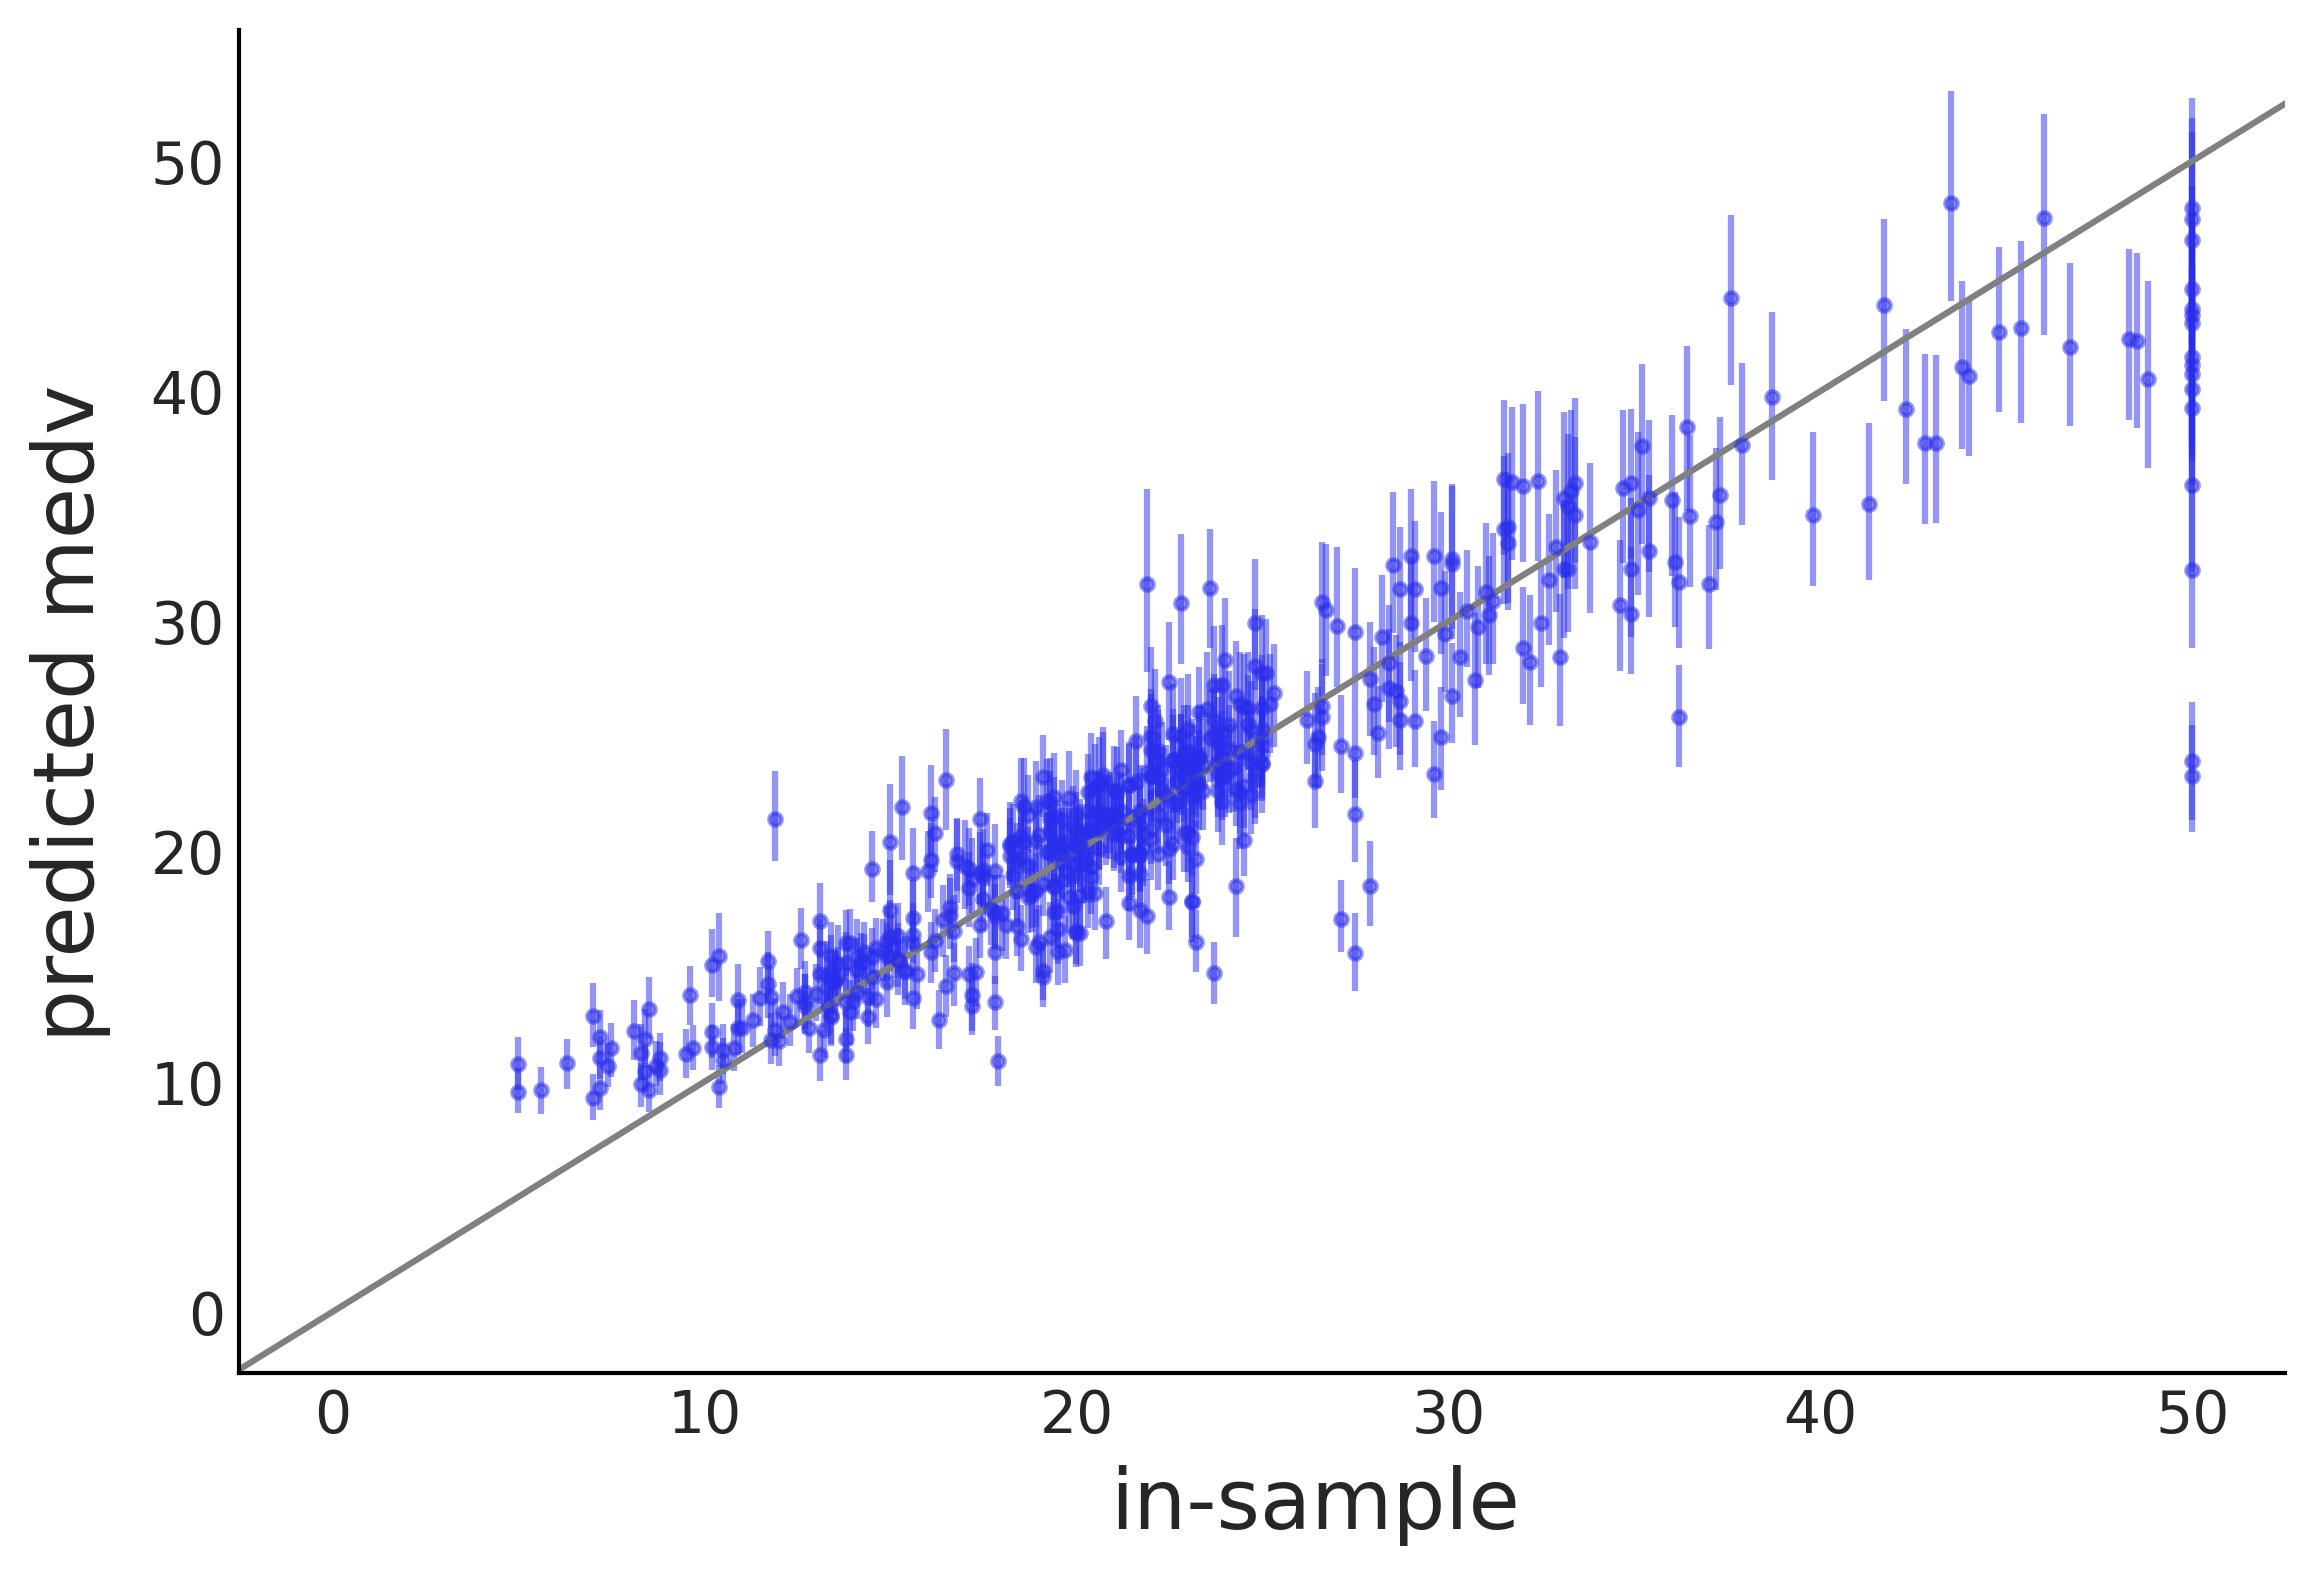

In [15]:
fig = plt.figure()

y_pred = idata_full.posterior["μ"].stack(samples=["chain", "draw"])
mean_y = y_pred.median("samples")
mean = y_pred.mean("samples")
hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
yerr = np.vstack([mean_y - hdi[:, 0], hdi[:, 1] - mean_y])
plt.errorbar(Y, mean_y, yerr, linestyle="None", marker=".", alpha=0.5)
plt.axline([0, 0], [1, 1], color="0.5")
print(np.mean((Y - mean) ** 2) ** 0.5)
fig.text(0.45, -0.05, "in-sample", fontsize=20)
fig.text(-0.05, 0.3, "predicted medv", fontsize=20, rotation=90);

In [16]:
idata_full.to_netcdf("boston_id_full_GM.nc");

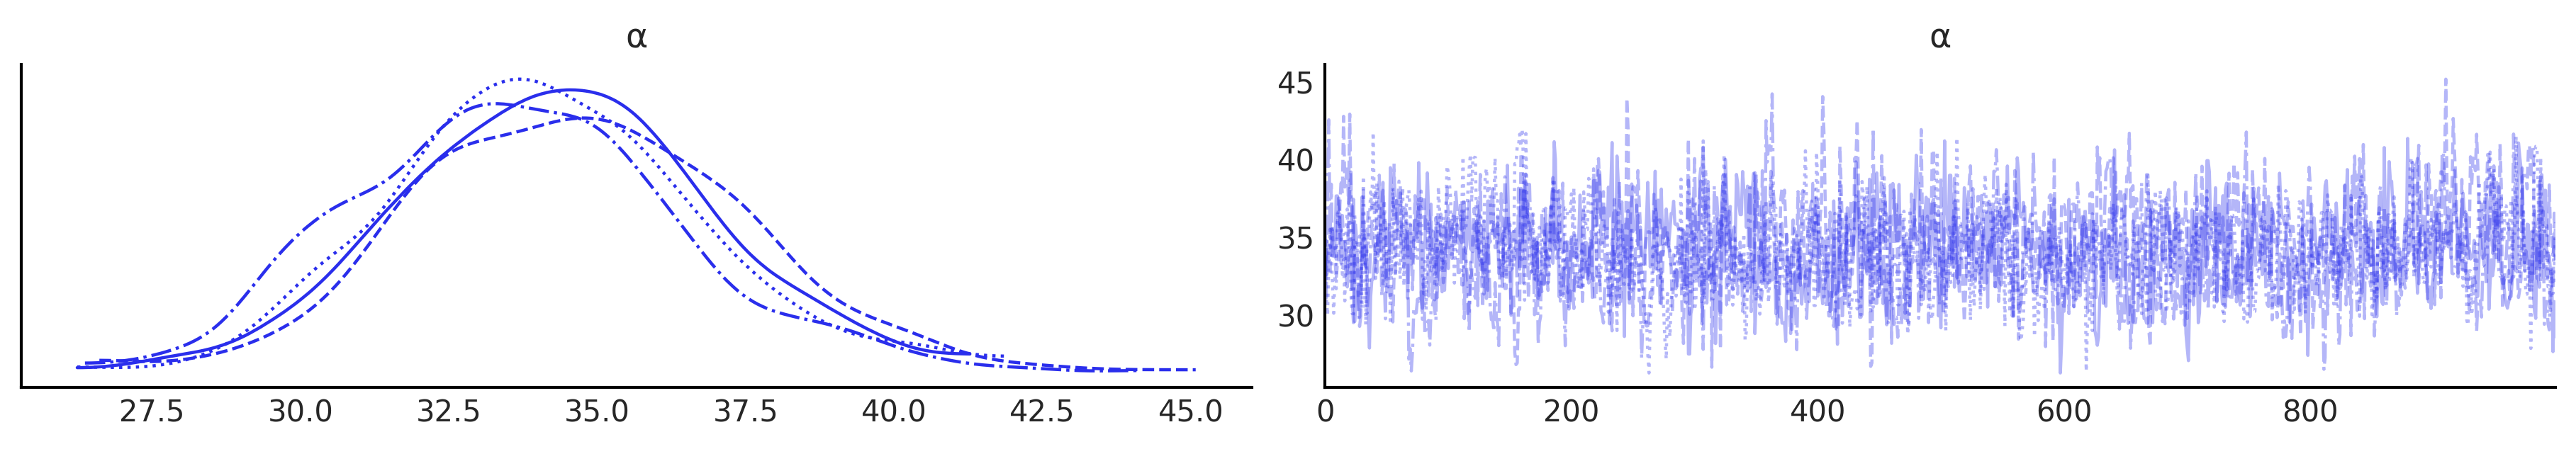

In [17]:
az.plot_trace(idata_full, var_names=["α"]);

In [18]:
az.loo(idata_full)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 506 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1397.74    32.20
p_loo       63.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      498   98.4%
 (0.5, 0.7]   (ok)          4    0.8%
   (0.7, 1]   (bad)         2    0.4%
   (1, Inf)   (very bad)    2    0.4%

In [19]:
az.summary(idata_full, var_names=["α"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,34.182,2.688,29.284,39.252,0.11,0.078,572.0,1306.0,1.01


## With Gaussian distribution  
### Using the two most important variables  

In [20]:
with pm.Model() as model:
    σ = pm.HalfNormal("σ", 5)
    μ = pmb.BART("μ", X1, Y, m=200)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)
    idata_gauss = pm.sample(
        chains=4, random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 227 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [21]:
idata_gauss.to_netcdf("boston_id_2v_GAUSS.nc");

In [22]:
az.loo(idata_gauss)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 506 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1469.16    36.00
p_loo       32.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      502   99.2%
 (0.5, 0.7]   (ok)          2    0.4%
   (0.7, 1]   (bad)         2    0.4%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
az.summary(idata_gauss, var_names=["σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,4.266,0.139,3.997,4.517,0.004,0.003,1410.0,2385.0,1.0


### Using all variables  

In [24]:
with pm.Model() as model:
    σ = pm.HalfNormal("σ", 5)
    μ = pmb.BART("μ", X_full, Y, m=200)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)
    idata_full_gauss = pm.sample(
        chains=4,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 224 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [25]:
idata_full_gauss.to_netcdf("boston_id_full_GAUSS.nc");

In [26]:
az.summary(idata_full_gauss, var_names=["σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,3.733,0.149,3.455,4.01,0.005,0.003,932.0,1778.0,1.01


In [27]:
az.loo(idata_full_gauss)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 506 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1426.47    44.72
p_loo       72.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      495   97.8%
 (0.5, 0.7]   (ok)          6    1.2%
   (0.7, 1]   (bad)         3    0.6%
   (1, Inf)   (very bad)    2    0.4%

## Run model with R-BART  
This generate an output file `Boston_housing_values-R_01.r.Rout`

In [28]:
!R CMD BATCH Boston_housing_values-R_01.r